### Check quality of local drone movement calculation  

Compare difference between locations projected into map from same frame but two different camera matrices. The first camera matrix used for each comparison is the  camera matrix of the last anchor plus the local movement estimation up to the next anchor frame. The second camera matreix used for each comparrison is the actual computed camera matrix for the next camera frame calculated in the structure from motion step. If the local drone movement estimiation was correct the animal positions in a given anchor frame projected through these two matricies should be very close to each other in the 3D map. If it wasn't done well then they could be far appart for certain or all positions in that anchor frame. This distance is a way to estimate the maximum expected possiible projection error introduced by the local drone movement calcualtion step for each set of frames between anchors. 

In [1]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np

# local .json file with local path info
geladas_root = os.path.dirname(os.getcwd())
local_paths_file = os.path.join(geladas_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

import koger_general_functions as kgf
import mapping_functions as kmap

plt.style.use('dark_background')

In [2]:
# change to specific observation name 
observation_name = "DJI_0205"
# Name of the track file that should be projected into landscape
tracks_name = "tracks-complete.npy"
# Name of folder where data extracted in "extract_drone_movement.ipynb" was saved
drone_movement_folder_name = "worked_examples_drone_movement"
# Project name assosiated with the saved pix4d files
pix4d_project_name = "gelada_worked_example_DJI_0205"

In [3]:
frame_folders_root = os.path.join(local_paths['base_frames_folder'], observation_name)
frame_files = sorted(glob.glob(os.path.join(frame_folders_root, "*.jpg")))

map_folder = os.path.join(local_paths['pix4d_folder'], observation_name)
pix4d_info = kmap.get_pix4d_info(map_folder, pix4d_project_name, pmatrix_sort='simple')
anchor_obs_indexes = kmap.get_anchor_obs_indexes(pix4d_info['pmatrices'], 
                                                 frame_files=frame_files)

tracks_file = os.path.join(local_paths['base_gelada'], "processing", 
                           observation_name, "raw_tracks.npy")
tracks = np.load(tracks_file, allow_pickle=True)

drone_movement_folder = os.path.join(frame_folders_root, drone_movement_folder_name)

segment_movement_files = glob.glob(
    os.path.join(drone_movement_folder,"drone_movement_segment_*.npy"))
segment_movements = [np.load(file) for file in sorted(segment_movement_files)]
segment_inlier_files = glob.glob(
    os.path.join(drone_movement_folder,"inliers_segment_*.npy"))
segment_inliers = [np.load(file) for file in sorted(segment_inlier_files)]

In [4]:
# Parameters for projecting points from video frame in to the map
# (meters) consider points on ray within .1 meters of ground to be "on ground"
correct_threshold = 1.0
# max guesses to search for point on ray within correct_threshold of the ground
max_guesses = 100 
# Where to start searching along the ray
mu_est = 100
frame_shape = plt.imread(frame_files[0]).shape

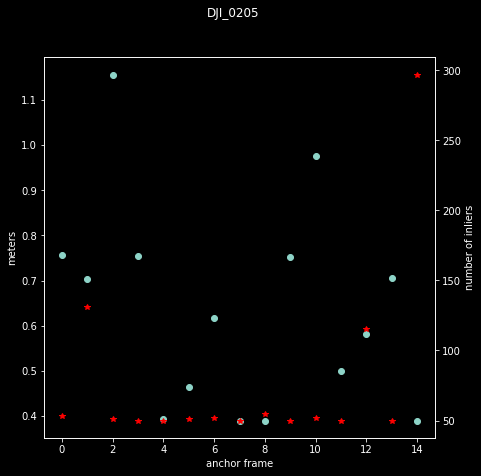

In [15]:
save_fig = True

segment_errors = []

for anchor_ind, anchor_obs_ind in enumerate(anchor_obs_indexes[1:]):
    segment_errors.append(
        kmap.calculate_total_segment_error(tracks, anchor_obs_ind, anchor_ind, 
                                           pix4d_info, segment_movements,
                                           mu_est, max_guesses, correct_threshold, 
                                           frame_shape, object_height=1
                                          )
    )



distances = [np.linalg.norm(e, axis=1) for e in segment_errors]
max_distances = [np.nanmax(d) for d in distances]
mean_distances = [np.nanmean(d) for d in distances]

min_inliers = [np.min(i) for i in segment_inliers]

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(max_distances, 'o')
# plt.plot(mean_distances, 'o')
fig.suptitle(observation_name)
ax2 = plt.gca().twinx()
ax2.plot(min_inliers, 'r*')
ax.set_xlabel("anchor frame")
ax.set_ylabel("meters")
ax2.set_ylabel("number of inliers")

file = os.path.join(local_paths['figure_folder'], 
                    f"gelada_inliers.png")
if save_fig:
    plt.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight',
               transparent=True)

### If some of the values are high, may want to investigate further

#### Can check if certain frames have high error across it, or just certain
#### locations

In [45]:
import cv2

In [46]:
# Can create a grid of points across the frame to see how possible
# error changes across the whole frame (may or may not be
# relevant depending on where animals are standing)

samples_per_column = 10
samples_per_row = 20
simulated_tracks = kmap.simulate_tracks_across_frame(frame_shape, len(frame_files),
                                                     samples_per_column, 
                                                     samples_per_row)

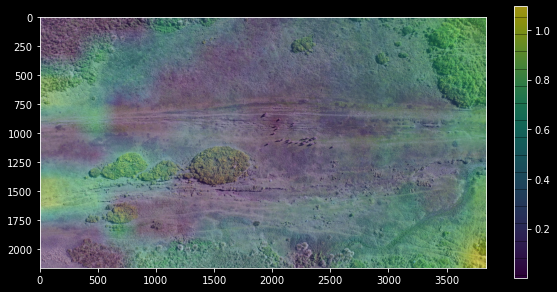

In [53]:
anchor_ind = 1
obs_ind = anchor_obs_indexes[anchor_ind+1]
segment_error = kmap.calculate_total_segment_error(simulated_tracks, obs_ind, 
                                                   anchor_ind, pix4d_info, 
                                                   segment_movements, mu_est, 
                                                   max_guesses, correct_threshold, 
                                                   frame_shape, object_height=1)


frame = plt.imread(frame_files[obs_ind])
distances = np.linalg.norm(segment_error, axis=1)
distances = np.reshape(distances, (samples_per_column, samples_per_row))
distances = cv2.resize(distances, (frame.shape[1], frame.shape[0]))
plt.figure(figsize=(10, 5))
plt.imshow(frame)
plt.imshow(distances, alpha=.4)
plt.colorbar()

### Investigate estimated movement between anchor frame pairs

Text(0.5, 1.0, 'Observation index: 2829 - raw')

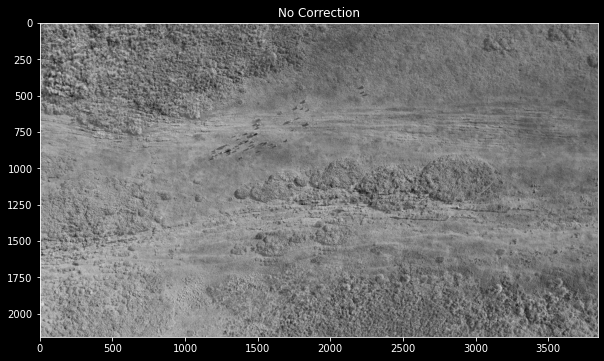

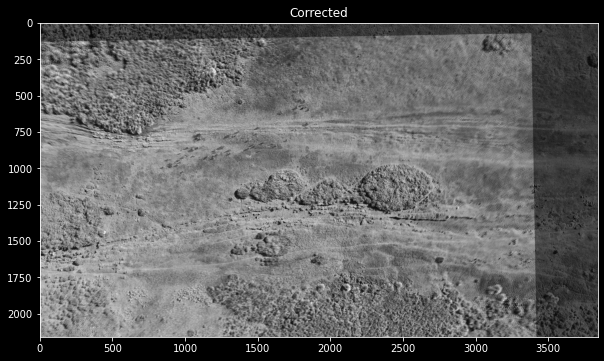

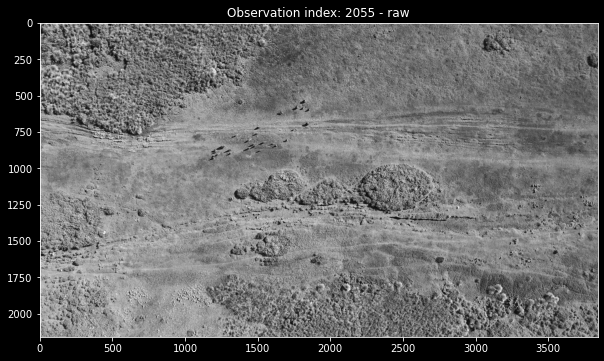

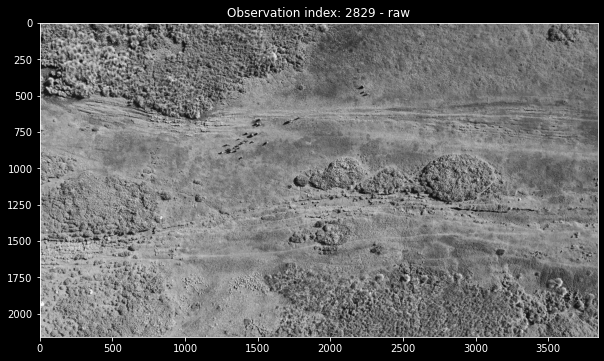

In [54]:
anchor_ind = 4

frame0_raw = cv2.imread(frame_files[anchor_obs_indexes[anchor_ind]])
frame0_gray = cv2.cvtColor(frame0_raw, cv2.COLOR_BGR2GRAY)

frame1_raw = cv2.imread(frame_files[anchor_obs_indexes[anchor_ind+1]])
frame1_gray = cv2.cvtColor(frame1_raw, cv2.COLOR_BGR2GRAY)

warp = segment_movements[anchor_ind][-1]

warped_image = cv2.warpAffine(frame1_gray, M=warp[:2], 
                              dsize=(frame0_raw.shape[1], frame0_raw.shape[0]))

plt.figure(figsize=(10, 10))
plt.imshow(frame0_gray, cmap='gray', )
plt.imshow(frame1_gray, alpha=.5, cmap='gray')
plt.title("No Correction")

plt.figure(figsize=(10, 10))
plt.imshow(frame0_gray, cmap='gray', )
plt.imshow(warped_image, alpha=.5, cmap='gray')
plt.title("Corrected")

plt.figure(figsize=(10, 10))
plt.imshow(frame0_gray, cmap='gray')
plt.title(f"Observation index: {anchor_obs_indexes[anchor_ind]} - raw")
plt.figure(figsize=(10, 10))
plt.imshow(frame1_gray, alpha=1.0, cmap='gray')
plt.title(f"Observation index: {anchor_obs_indexes[anchor_ind+1]} - raw")